(sec:scikit-learn)=
# scikit-learnによる機械分類の基本

この項では、scikit-learn を用いた機械学習の基礎と、得られた結果の評価方法について学ぶ。

scikit-learn は様々な機械学習の手法が統一的なコードにより使用できるように整備されたライブラリである。例えば、機械学習器のパラメータをデータセットに合わせて調整するには`fit`という関数を用い、機械学習器を用いた予測には`predict`という関数を使う、といった具合である。


In [1]:
"""
下準備のコード
"""

import os
import random
import warnings
from itertools import product

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.exceptions import ConvergenceWarning

try:
    from myst_nb import glue
except ImportError:
    glue = lambda *args, **kwargs: _


# グラフの設定
rc = {"figure.dpi": 150}
sns.set_theme(style="white", palette="colorblind", rc=rc)

# シードの固定
random.seed(31415)
np.random.seed(31415)

# 実験に使うデータ数
n_samples = 10000
glue("n_samples", n_samples, display=False)

# 一部の警告を無視
warnings.simplefilter("ignore", ConvergenceWarning)
warnings.simplefilter("ignore", FutureWarning)
os.environ["PYTHONWARNINGS"] = "ignore"

# 結果を格納していくDataFrame
result_df = pd.DataFrame(
    {
        "Method": pd.Series([], dtype="string"),
        "Accuracy": pd.Series([], dtype="float64"),
        "Phase": pd.Series([], dtype="string"),
    }
)

## 分類問題 (classification)


まずは、scikit-learnのいくつかの機械学習器を用いて手書き文字のデータセットである**MNIST**(Modified National Institute of Standards and Technology)を分類してみる。

scikit-learnには`datasets`というモジュールがあり、ウェブ上に公開されているMNISTのデータを簡単にダウンロードできるので、今回はそれを利用する。

In [2]:
# 以下のコードはデータのダウンロードを伴うため、少々時間がかかる
from sklearn import datasets

X_org, y_org = datasets.fetch_openml(
    "mnist_784",
    return_X_y=True,
    data_home="./mnist",
    parser="auto",
)

# 画像は[0, 1]の範囲に正規化しておく
X_org = np.array(X_org / 255.0, dtype="double")
y_org = np.array(y_org, dtype="uint8")

上記の`fetch_openml`において第1引数の`mnist_784`はデータセットの名前で、本項で用いるMNISTは28x28(=784)画素の手書き数字を表わす白黒画像から成る。ダウンロード元の[OpenML](https://www.openml.org/search)では、他にも多くのデータセットが利用可能なので、興味のあるデータを検索してみると良い。

また`return_X_y`は関数の戻り値が画像データ`X`とラベル`y`になるようにするためのフラグで、最後の`data_home`は二度目以降にデータセットを使用するときに再度ダウンロードしないよう、データをキャッシュしておくディレクトリを指定している。

なお、特に`data_home`を指定しない場合はホームディレクトリに`scikit_learn_data`というディレクトリが作成され、その中にデータがキャッシュされる。一度目に上記のコードを実行すると、データのダウンロードに時間がかかるが、二度目以降はキャッシュされたデータを読み込むため時間が短縮される (それでも数秒はかかる)。

上記、scikit-learnの関数で得られるデータは[Pandas](https://pandas.pydata.org/)の`DataFrame`という方になっているのでおく。なお、データを画像として可視化すると以下のようになっている。

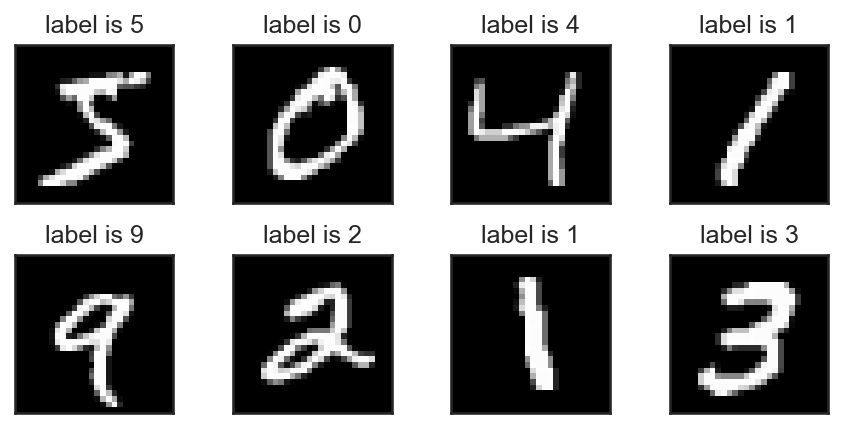

In [3]:
# 画像として見られるように配列の形を変更
ims = np.reshape(X_org[:8], (-1, 28, 28))

# 最初の5枚を確認してみる
fig, axs = plt.subplots(2, 4, figsize=(6, 3))
axs = axs.flatten()
for i in range(8):
    axs[i].imshow(ims[i], cmap="gray", vmin=0, vmax=1, interpolation=None)
    axs[i].set_title("label is {:d}".format(y_org[i]))
    axs[i].set(xticks=[], yticks=[])

plt.tight_layout()
plt.show()

MNIST のデータは訓練とテストのそれぞれに60000個, 10000 個のデータが用意されているので、`train_test_split`を用いてデータを分割しておく。


In [4]:
from sklearn import model_selection

# ランダムシャッフルした上でデータを訓練用と検証用に分割
X, X_test, y, y_test = model_selection.train_test_split(
    X_org, y_org, train_size=60000, test_size=10000, shuffle=True
)

なお、今回は計算時間の短縮のために、先頭{glue}`n_samples`個のデータだけを使って、以下の実験を行う。


In [5]:
X, y = X[:n_samples], y[:n_samples]
X_test, y_test = X_test[:n_samples], y_test[:n_samples]

## データのスケーリング


機械学習器にデータを学習させる前にデータのスケールを揃えておくと精度が改善する場合が多い。最も良く用いられる方法は**訓練データの平均と分散**を計算して、データの各次元の平均が 0、分散が1となるように変形する方法である。この方法は、scikit-learn の`StandardScaler`に実装されているので、今回はこれを使用する。


In [6]:
from sklearn.preprocessing import StandardScaler

# スケーリングパラメータの計算
scaler = StandardScaler()
scaler.fit(X)

# データのスケーリング
X_scaled = scaler.transform(X)
X_test_scaled = scaler.transform(X_test)

なお、実際の機械分類モデル (例えば`LinearRegression`)などと一緒に用いる場合には、`make_pipeline`関数を用いると、スケーリングにテスト用データを誤って使うと言った間違い(以下の注意を参照)を防ぐことができ、実装も簡単である。


```python
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

clf = make_pipeline(
  StandardScaler(),
  LinearRegression(),
)
clf.train(X, y)
```

::::{admonition} スケーリングする際の注意
:class: warning

データのスケーリングを行う場合、**スケールを決定するのに使えるデータは訓練データのみ**であることに注意する (テストデータがどんなデータなのかは事前に分からないため)。また、テストをする際にも、同様の(訓練データに基づいた)スケーリングをするのを忘れないようにすること。
::::

## 最近傍探索による分類


識別を行う上で、最も単純な方法は手書き文字の画像を多次元ベクトルと見なして、多次元空間の近傍に多く存在するサンプルのラベルを、未知のデータのラベルとして採用するというものだろう。それを実現するのが`KNeighborsClassifier`である。


In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier

# 識別モデルの構築
n_neighbors = 20
clf = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=n_neighbors),
)
clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=20))])

In [8]:
glue("n_neighbors", n_neighbors, display=False)

以下は、未知のデータが与えられた時、近傍の{glue}`n_neighbors`枚の画像を探索して、その画像の持つラベルの中で最も多いものを未知データに対するラベルとして採用する、というコードである。

In [9]:
# 識別精度の確認
acc_train = clf.score(X, y)
acc_test = clf.score(X_test, y_test)

In [10]:
glue("knn_acc_train", acc_train * 100.0)
glue("knn_acc_test", acc_test * 100.0)
result_df.loc[len(result_df), :] = ["k-nearest", acc_train, "Train"]
result_df.loc[len(result_df), :] = ["k-nearest", acc_test, "Test"]

90.27

89.5

**結果: 最近傍探索による分類**

- 訓練時精度: {glue:text}`knn_acc_train:.2f`%
- 評価時精度: {glue:text}`knn_acc_test:.2f`%


## ロジスティック回帰による分類


続いては入力を線形変換することで出力を予測する線形モデルの一種であるロジスティック回帰 (`LogisticRegression`)を使ってみる。

ロジスティック回帰のパラメータは行列$\mathbf{A} \in \mathbb{R}^{m \times n}$とバイアス項$\mathbf{b} \in \mathbb{R}^{m}$で多クラスの分類問題の場合には、入力$\mathbf{x} \in \mathbb{R}^{n}$に対して、ソフトマックス関数$\sigma(\cdot)$を用いて出力である分類ラベル$\mathbf{y} \in \mathbb{R}^{m}$を予測する。

$$
\mathbf{y} = \sigma(\mathbf{Ax} + \mathbf{b})
$$

なお、ソフトマックス関数は、入力$\mathbf{x}$を以下の式によって$\mathbf{x}'$へと変換する。

$$
x'_i = \sigma(\mathbf{x}) = \frac{\exp x_i}{\sum_{j=1}^n \exp x_j}
$$

従って、予測ラベル$\mathbf{y}$の各要素は0から1の値を取り、なおかつ$\mathbf{y}$の全要素の合計は1になる。このことから$\mathbf{y}$はラベルの予測確率を表わしており、この中で最も大きな値を持つ要素が予測識別の結果であると考えられる。


In [11]:
from sklearn.linear_model import LogisticRegression

# 訓練モデルの構築
lr_params = {
    "tol": 1.0e-3,
    "max_iter": 5000,
    "solver": "lbfgs",
}
clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(**lr_params),
)
clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=5000, tol=0.001))])

In [12]:
# 識別精度の確認
acc_train = clf.score(X, y)
acc_test = clf.score(X_test, y_test)

In [13]:
glue("logis_acc_train", acc_train * 100.0)
glue("logis_acc_test", acc_test * 100.0)
result_df.loc[len(result_df), :] = ["Logistic", acc_train, "Train"]
result_df.loc[len(result_df), :] = ["Logistic", acc_test, "Test"]

98.61999999999999

87.67

**結果: ロジスティック回帰による分類**

- 訓練時精度: {glue:text}`logis_acc_train:.2f`%
- 評価時精度: {glue:text}`logis_acc_test:.2f`%


::::{admonition} 問
:class: question

`ScandardScaler`を使う場合と使わない場合で、`LogisticRegression`の性能を比較せよ。
::::

## バギングによる分類


バギング(bagging)とは Bootstrap AGGregatING から作られた造語であり、訓練データの部分集合にあたる**ブートストラップ・サンプル**を用いて学習した異なる分類器の多数決によって、最終的な分類予測を行う機械学習法である**アンサンブル学習の一種**である。

例えば、訓練データが$N$個のサンプルからなる時、$M$個のサブサンプル ($M \leq N$)を取り出して、分類器を学習する。この操作を複数のサブサンプルと分類器に対して実行する。このようにブートストラップ・サンプルで訓練された分類器のことを**弱分類器**と呼ぶ。

最終結果は、単純には、得られた分類器の予測の中で一番多数の票を集めたものが与えられる。以下に単純なバギングの実装例を与える。


In [14]:
# 単純なバギングの実装例
n_bootstrap = int(0.5 * len(X))
n_estims = 10

## 訓練
estims = []
for i in range(n_estims):
    randidx = np.random.randint(len(X), size=(n_bootstrap))
    X_smp = X[randidx, :]
    y_smp = y[randidx]
    estim = LogisticRegression(**lr_params)
    estim.fit(X_smp, y_smp)
    estims.append(estim)

In [15]:
## 予測
n_classes = 10
vote = np.zeros((len(y_test), n_classes), dtype="int32")
for estim in estims:
    y_sub = estim.predict(X_test)
    temp = np.take_along_axis(vote, y_sub[:, None], axis=1)
    np.put_along_axis(vote, y_sub[:, None], temp + 1, axis=1)

y_pred = np.argmax(vote, axis=1)

In [16]:
# 精度計算
acc_test = 100.0 * np.sum(y_pred == y_test) / len(y_test)
print("Bagging: acc(test)={:.2f}%".format(acc_test))

Bagging: acc(test)=90.73%


バギングをscikit-learnの(`BaggingClassifier`)を用いて実装した場合には以下のようになる。

In [17]:
from sklearn.ensemble import BaggingClassifier

# 訓練モデルの構築 (弱識別器にロジスティック回帰を使用)
weak_clf = LogisticRegression(**lr_params)
clf = make_pipeline(
    StandardScaler(),
    BaggingClassifier(estimator=weak_clf, n_estimators=10),
)
clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('baggingclassifier',
                 BaggingClassifier(estimator=LogisticRegression(max_iter=5000,
                                                                tol=0.001)))])

In [18]:
# 識別精度の確認
acc_train = clf.score(X, y)
acc_test = clf.score(X_test, y_test)

In [19]:
glue("bag_acc_train", acc_train * 100.0)
glue("bag_acc_test", acc_test * 100.0)
result_df.loc[len(result_df), :] = ["Bagging", acc_train, "Train"]
result_df.loc[len(result_df), :] = ["Bagging", acc_test, "Test"]

97.74000000000001

89.57000000000001

**結果: バギングによる分類**

- 訓練時精度: {glue:text}`bag_acc_train:.2f`%
- 評価時精度: {glue:text}`bag_acc_test:.2f`%


バギングは、部分データを用いて学習した複数の分類器を組み合わせているだけなので、弱分類に用いる分類器(上記の例では`LogisticRegression`)と比べて、それほど精度が増加しないことが多い。これは、部分データ同士の相関が大きく、結果として、弱分類器の予測が似通ってしまうことに起因する。


## ランダム・フォレストによる分類


ランダム・フォレストはバギングの弱分類器による推論が似通ってしまう問題を解決するアンサンブル学習法の一つである。バギングにおいて、予測が偏ってしまう問題は、ブートストラップ・サンプルのサイズ$M$が十分$N$に近い場合に、訓練データの分布が似通ってしまうことに原因がある。

そこで、ランダム・フォレストでは、訓練データからブートストラップ・サンプルを抽出し、さらに、その特徴のうちランダムに数個だけを選んで弱分類器を学習する。即ち、学習する特徴ベクトルが$C$次元であるとして、その中から$c$ ($c \geq C$)だけをランダムに抽出したものを特徴ベクトルとして学習を行う。

このようにすることで十分に$N$に近い$M$であっても、分布の異なるサンプル集合を得ることができる。以下に簡易実装を示す。

In [20]:
from sklearn.tree import DecisionTreeClassifier

# 単純なランダム・フォレストの実装例
n_data, n_dim = X.shape
n_bootstrap = int(0.5 * n_data)
n_estims = 10
n_sub_dim = int(0.5 * n_dim)

## 訓練
estims = []
dims = []
for i in range(n_estims):
    randsmp = np.random.randint(n_data, size=(n_bootstrap))
    randdim = np.random.randint(n_dim, size=(n_sub_dim))
    X_smp = X[randsmp, :]
    X_smp = X_smp[:, randdim]
    y_smp = y[randsmp]
    estim = DecisionTreeClassifier()
    estim.fit(X_smp, y_smp)
    estims.append(estim)
    dims.append(randdim)

In [21]:
## 予測
n_classes = 10
vote = np.zeros((len(y_test), n_classes), dtype="int32")
for i, estim in enumerate(estims):
    X_sub = X_test[:, dims[i]]
    y_sub = estim.predict(X_sub)
    temp = np.take_along_axis(vote, y_sub[:, None], axis=1)
    np.put_along_axis(vote, y_sub[:, None], temp + 1, axis=1)

y_pred = np.argmax(vote, axis=1)

In [22]:
# 精度計算
acc_test = 100.0 * np.sum(y_pred == y_test) / len(y_test)
print("Random Forest: acc(test)={:.2f}%".format(acc_test))

Random Forest: acc(test)=90.82%


ランダム・フォレストをscikit-learnの`RandomForestClassifier`を用いて実装した場合には以下のようになる。なお、scikit-learn のランダム・フォレストは弱分類器に決定木しか使えないため、バギングの時のように弱分類器のモデルを指定することはできない。

In [23]:
from sklearn.ensemble import RandomForestClassifier

# 訓練モデルの構築 (弱識別器にロジスティック回帰を使用)
clf = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(),
)
clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier', RandomForestClassifier())])

In [24]:
# 識別精度の確認
acc_train = clf.score(X, y)
acc_test = clf.score(X_test, y_test)

In [25]:
glue("rf_acc_train", acc_train * 100.0)
glue("rf_acc_test", acc_test * 100.0)
result_df.loc[len(result_df), :] = ["Random forest", acc_train, "Train"]
result_df.loc[len(result_df), :] = ["Random forest", acc_test, "Test"]

100.0

95.0

**結果: ランダム・フォレストによる分類**

- 訓練時精度: {glue:text}`rf_acc_train:.2f`%
- 評価時精度: {glue:text}`rf_acc_test:.2f`%


## AdaBoostによる分類

バギングを拡張したアンサンブル学習には、ランダム・フォレスト以外にも**ブースティング**という手法がある。

ブースティングは、バギングのように独立した弱分類器を学習するのではなく、弱分類器の列を順に学習していく。この際、新しく列に追加される弱分類器は、**それまでの学習結果で上手く分類できていないサンプルをより良く識別するように補正**をいれて学習する。

このようなブースティング法には多くのバリエーションがあるが、ここではその代表格である**AdaBoost**を紹介する。AdaBoost の大まかな学習手順は以下のようになる。

1. 弱分類器$f_1$を訓練データ$(\mathbf{x}_i, y_i)$から作成する。
2. 弱分類器$f_1$の訓練データ$y_i$に対する識別精度を求め、その識別精度が悪い物に対して大きな重み$w_i$を割り当てる。
3. 重み$w_i^{(1)}$によってサンプルの重要度を変えて、次の弱識別器$f_2$を学習する。
4. 以下、$f_{t-1}$の識別精度から次の弱識別器の学習に用いる重み$w_i^{(t-1)}$を計算し、弱識別器の学習を繰り返す。

このようにして得られた弱識別器の予想を重み付き平均することにより、未知データに対する予測を得る。

$$
y = \sum_{i=1}^{n_{\rm weak}} \alpha_i f_i(\mathbf{x})
$$

なお、$n_{\rm weak}$は弱識別器の数を表わし、$\alpha_i$は各識別器の正確さに基づく重みである。

scikit-learn を用いたAdaBoostによる識別には`AdaBoostClassifier`を用いる。

In [26]:
from sklearn.ensemble import AdaBoostClassifier

# 訓練モデルの構築 (弱識別器にロジスティック回帰を使用)
weak_clf = LogisticRegression(**lr_params)
clf = make_pipeline(
    StandardScaler(),
    AdaBoostClassifier(estimator=weak_clf, n_estimators=50),
)
clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('adaboostclassifier',
                 AdaBoostClassifier(estimator=LogisticRegression(max_iter=5000,
                                                                 tol=0.001)))])

In [27]:
# 識別精度の確認
acc_train = clf.score(X, y)
acc_test = clf.score(X_test, y_test)

In [28]:
glue("ada_acc_train", acc_train * 100.0)
glue("ada_acc_test", acc_test * 100.0)
result_df.loc[len(result_df), :] = ["AdaBoost", acc_train, "Train"]
result_df.loc[len(result_df), :] = ["AdaBoost", acc_test, "Test"]

81.63

80.84

**結果: AdaBoost による分類**

- 訓練時精度: {glue:text}`ada_acc_train:.2f`%
- 評価時精度: {glue:text}`ada_acc_test:.2f`%


```{warning}
上記の例では弱識別器にロジスティック回帰を用いているが、それにも関わらず、**ロジスティック回帰を単体で用いる場合に比べて精度が落ちている**ことが分かる。これは、AdaBoostにおいて、

1. 弱分類器の学習は、単体の分類器の学習よりも甘めに行われる (最適化問題を最後まで収束させない)
1. 分類が上手くいかないデータが多い場合には、重み付け操作により、そのようなノイズデータに過剰適合しやすくなる

という問題があるためであり、より高い精度を得るためには、ハイパーパラメータのチューニングが必要になってくる。
```


## 勾配ブースティングによる分類


ブースティングの手法には勾配ブースティングと呼ばれる手法もある。AdaBoost では、$f_{t-1}$で分類が上手くいっていないサンプルに**重みを強くつける**という方法で識別精度が上がるように補正を掛けていた。

勾配ブースティングは、$f_{t-1}$までの**識別誤差**を補正するように次の弱分類器$f_{t}$を学習する。言い換えると、各弱分類器は分類問題を解くのではなく、分類の誤差を補正するような**勾配を予測する問題**を解く。従って、勾配ブースティングは各弱分類器の予測を多数決で採用するのではなく、全ての弱分類器を統合した分類器$F_t$が一つの予測を返す。

勾配ブースティングの大まかな学習手順は以下のようになる。

1. $F_1 = f_1$ を訓練データ $(\mathbf{x}_i, y_i)$ から作成する。
2. 現在の予測ベクトル $y_i^{(1)}$ による誤差 $L$ の勾配を以下のように計算する。

$$
r_i^{(1)} = -\frac{\partial L(y_i)}{\partial y_i}
$$

3. この残差 $r_i^{(1)}$ を最小化するように $f_2$ を訓練データ $(\mathbf{x}_i, r_i^{(1)})$ により学習する。
4. $f_2$により与えられる勾配の予測値$h_2$を用いて誤差が最も下がるステップ幅$\gamma$をラインサーチによって求める。
5. $F_2(\mathbf{x}) = f_1(\mathbf{x}) + \gamma f_2(\mathbf{x})$と更新する。
6. 以下、2.から 5.のステップを新たな$f_t$に対して繰り返す。

以下に、scikit-learnの`GradientBoostingClassifier`を用いた実装を示す。

なお、勾配ブースティングは新たな弱分類器を学習するために、残差に対する回帰問題と、ラインサーチのステップを繰り返すため、AdaBoost 等の他のブースティングのアルゴリズムに比べて多くの計算時間を要する。そのため、以下のプログラムでは、`n_estimator`の数を小さめに設定している。

In [29]:
from sklearn.ensemble import GradientBoostingClassifier

# 訓練モデルの構築
clf = make_pipeline(
    StandardScaler(),
    GradientBoostingClassifier(n_estimators=20),
)
clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(n_estimators=20))])

In [30]:
# 識別精度の確認
acc_train = clf.score(X, y)
acc_test = clf.score(X_test, y_test)

In [31]:
glue("gbst_acc_train", acc_train * 100.0)
glue("gbst_acc_test", acc_test * 100.0)
result_df.loc[len(result_df), :] = ["Gradient boosting", acc_train, "Train"]
result_df.loc[len(result_df), :] = ["Gradient boosting", acc_test, "Test"]

89.77000000000001

87.0

**結果: 勾配ブースティングによる分類**

- 訓練時精度: {glue:text}`gbst_acc_train:.2f`%
- 評価時精度: {glue:text}`gbst_acc_test:.2f`%


::::{admonition} 勾配ブースティングは非深層学習の有望株？
:class: note

現在、深層学習を用いない機械分類のアルゴリズムの中では勾配ブースティングの発展形が大きな成果を挙げている。その中には**XGBoost** {cite}`chen2016xgboost` や**LightGBM** {cite}`ke2017lightgbm`などがあり、いずれもscikit-learnと類似したインターフェースで利用が可能なので、興味がある読者はこれらのライブラリを試してみとともに、原著の論文についても、ぜひ目を通してほしい。
::::

(ssec:support-vector-machine)=

## サポートベクトルマシンによる分類


サポートベクトルマシンは元々、2 クラス分類に対して提案された手法で、**サポートベクトル**という境界線(より厳密には超平面)を2つのクラスに属するデータ集合から求める問題を解く。

具体的には、データ空間の中で定義される超平面$\mathbf{a} \cdot \mathbf{x} + b=0$について、2つのクラスが$y_i \in \{ +1, -1 \}$のラベルを持つとして、以下の距離を最大化するような超平面のパラメータ$(\mathbf{a}, b)$を求める。

点と超平面との距離$d(\mathbf{x}_i)$は、$y_i$の符号を考慮すると、

$$
d(\mathbf{x}_i) = \frac{|\mathbf{a} \cdot \mathbf{x}_i + b|}{\| \mathbf{a} \|} = \frac{y_i (\mathbf{a} \cdot \mathbf{x}_i + b)}{\| \mathbf{a} \|}
$$

のように表せる。

このとき、サポートベクトルマシンでは、この距離を全てのサンプルに対して和を取るのではなく、サポートベクトルに最も近いサンプルまでの距離を最大化するように取るのがポイントで、このサポートベクトルまでの距離のことを「マージン」と呼ぶ。

従って、このマージンの値を$M$と置くと、解くべき最大化問題は、

$$
\max_{M, \mathbf{a}, b} M \quad \text{s.t.} \quad \frac{y_i (\mathbf{a} \cdot \mathbf{x}_i + b)}{\| \mathbf{a} \|} \geq M \quad \text{for}~~i=1, \ldots, N
$$

のように書ける。問題を簡単にするために、目的関数と制約式の両方に$\frac{\| \mathbf{a} \|}{M}$を乗ずると、最大化問題は、以下のように書き直せる。

$$
\max_{M, \mathbf{a}, b} \frac{1}{\| \mathbf{a} \|} \quad \text{s.t.} \quad y_i (\mathbf{a} \cdot \mathbf{x}_i + b) \geq 1 \quad \text{for}~~i=1, \ldots, N
$$

このとき、目的関数の最大化は$\| \mathbf{a} \|$の最小化とも見なせるので、適当な誤差関数として最小二乗誤差を取って以下のように書き直す (通常はHinge誤差が使われる)。

$$
\min_{\mathbf{a}, b} \frac{1}{2} \| \mathbf{a} \|^2 \quad \text{s.t.} \quad y_i (\mathbf{a} \cdot \mathbf{x}_i + b) \geq 1 \quad \text{for}~~i=1, \ldots, N
$$

あとはこの問題を未定乗数法を用いて解けば良い。


上記の式にLagrangeの未定乗数法を適用してLagrange関数を求めると、

$$
\begin{aligned}
\mathcal{L}(\mathbf{a}, b, \boldsymbol{\lambda})
&= \frac{1}{2} \| \mathbf{a} \|^2 - \boldsymbol{\lambda}^\top (\mathbf{y} \odot (\mathbf{X} \mathbf{a} + b \mathbf{1}) - \mathbf{1}) \\
&= \frac{1}{2} \| \mathbf{a} \|^2 - \boldsymbol{\lambda}^\top (\mathbf{Y} \mathbf{X} \mathbf{a} + b \mathbf{y} - \mathbf{1})
\end{aligned}
$$

のように書ける。ただし、$\mathbf{Y}$は$\mathbf{y}$の要素を対角成分に持つ対角成分である。この関数の勾配が0になる箇所を求めれば、所望の$(\mathbf{a}, b)$が得られるので、以下の連立方程式を解けば良い。

$$
\begin{aligned}
\frac{\partial \mathcal{L}}{\partial \mathbf{a}} &= \mathbf{a} - \mathbf{X}^\top \mathbf{Y}^\top \boldsymbol{\lambda} = \mathbf{0} \\
\frac{\partial \mathcal{L}}{\partial b} &= -\boldsymbol{\lambda}^\top \mathbf{y} = 0 \\
\frac{\partial \mathcal{L}}{\partial \boldsymbol{\lambda}} &= -\mathbf{Y} \mathbf{X} \mathbf{a} - b \mathbf{y} + \mathbf{1} = \mathbf{0}
\end{aligned}
$$


この連立方程式は$(\mathbf{a}, b, \boldsymbol{\lambda})$に対して線形になっており、以下のように書き直せる。

$$
\begin{pmatrix}
\mathbf{I} & \mathbf{0} & -\mathbf{X}^T \mathbf{Y}^T \\
\mathbf{0}^T & 0 & \mathbf{y}^T \\
\mathbf{YX} & \mathbf{y} & \mathbf{O}
\end{pmatrix}
\begin{pmatrix}
\mathbf{a} \\ b \\ \boldsymbol{\lambda}
\end{pmatrix} =
\begin{pmatrix}
\mathbf{0} \\ 0 \\ \mathbf{1}
\end{pmatrix}
$$


単純のために、二次元空間において、$(-1, 0)$, $(+1, 0)$の二点を中心とするガウス分布から2クラスのサンプルを抽出し、上記のLagrange関数を最小化してみる。

In [32]:
data_size = 250
X_1 = np.random.multivariate_normal(mean=(-1, 0), cov=0.05 * np.eye(2), size=(data_size))
y_1 = np.ones((data_size)) * (-1.0)
X_2 = np.random.multivariate_normal(mean=(+1, 0), cov=0.05 * np.eye(2), size=(data_size))
y_2 = np.ones((data_size)) * (+1.0)

X_two_class = np.concatenate([X_1, X_2], axis=0)
y_two_class = np.concatenate([y_1, y_2], axis=0)

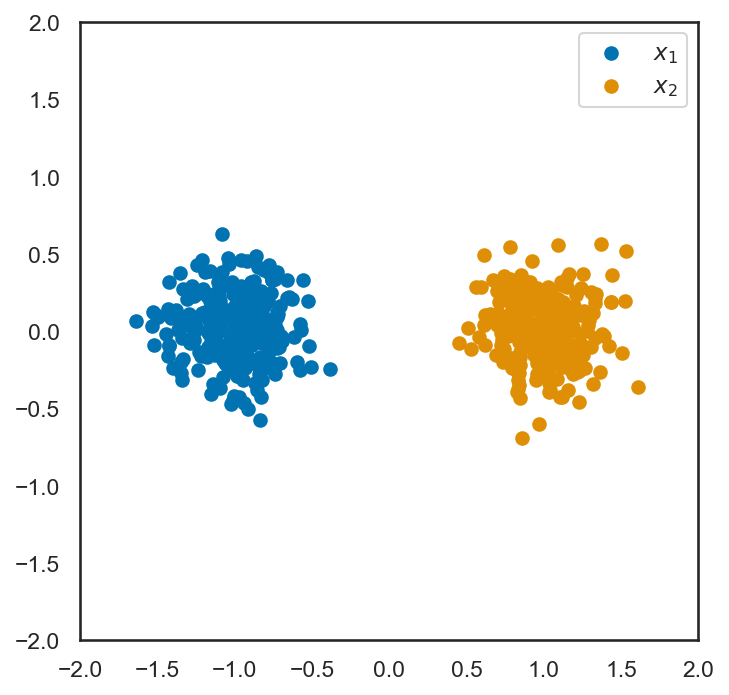

In [33]:
plt.scatter(X_1[:, 0], X_1[:, 1], label="$x_1$")
plt.scatter(X_2[:, 0], X_2[:, 1], label="$x_2$")
plt.legend()
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.gca().set_aspect("equal")
plt.tight_layout()
plt.show()

このサンプルデータに対して、上記の連立方程式を作成し、サポートベクトルとなる直線の方程式を求める。


In [34]:
YX = np.diag(y_two_class) @ X_two_class
matA = np.block(
    [
        [np.eye(2), np.zeros((2, 1)), -YX.T],
        [np.zeros((1, 2)), np.zeros((1, 1)), y_two_class[None, :]],
        [YX, y_two_class[:, None], np.zeros((len(y_two_class), len(y_two_class)))],
    ]
)
matB = np.zeros((matA.shape[1]))
matB[-len(y_two_class) :] = 1.0

ans = np.linalg.solve(matA + np.eye(len(matA)) * 1.0e-4, matB)
a_ = ans[:2]
b_ = ans[2]

最後に、ここで求めた`a_`ならびに`b_`を使って、先ほどの散布図にサポートベクトルを描画してみる。


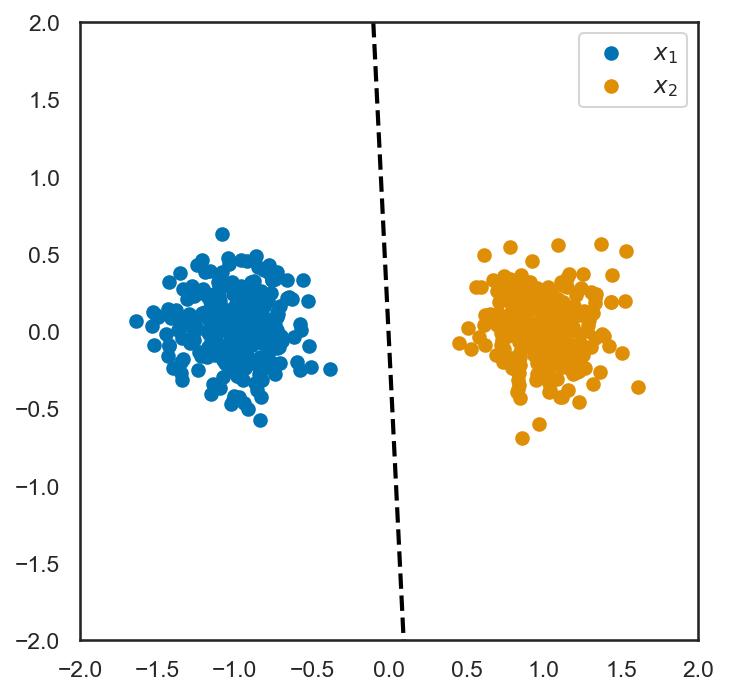

In [35]:
# サポートベクトルの端点を求める
x_min = -5
y_min = -1.0 * (a_[0] * x_min + b_) / a_[1]
x_max = +5
y_max = -1.0 * (a_[0] * x_max + b_) / a_[1]

# サポートベクトルの描画
# NOTE: 直線を描くとグラフの範囲がずれるので、直線を描く前の範囲を保存しておく
plt.scatter(X_1[:, 0], X_1[:, 1], label="$x_1$")
plt.scatter(X_2[:, 0], X_2[:, 1], label="$x_2$")
plt.axline((x_min, y_min), (x_max, y_max), color="black", linestyle="--", linewidth=2)
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.legend()
plt.gca().set_aspect("equal")
plt.tight_layout()
plt.show()

この通り、正しくサポートベクトルが求められていることが確認できる。なお、上記は二つのクラスラベルを持つサンプルがサポートベクトルの両側に分かれて存在することを仮定した最適化を行っている。


```{note}
実際のサンプルは、必ずしもサポートベクトルの両側にサンプルが分かれて存在する物ばかりではなく、分布が重なっている場合もあるので、その場合には、より複雑な最適化問題を解く必要がある。
```


以下ではSVMを使って、MNIST のデータを分類していく。多クラス分類の場合には、one-vs-one 方式の二つの方式があり、それぞれ以下のような方法を指す。

- **one-vs-one方式:** $K$個あるクラスの任意1のペアに対し1ラ1学習させる。従って合計で$K(K-1)/2$個のSVMモデルを学習する必要がある。
- **one-vs-rest方式:** $K$個あるクラスのうちの任意1を選び、そのクラスに属するか属さないか1ラ1学習させる。従って合計で$K$個のSVMモデルを学習すれば良い。

scikit-learnにおいてSVMによる分類を行うには`SVC`クラスを用いるが、このコンストラクタには`decision_function_shape=...`というパラメータがあり、これが`"ovo"`ならone-vs-one方式が、`"ovr"`(初期値)ならone-vs-rest方式が用いられる。

また、`SVC`のパラメータである`C=...`は、どの程度の割合でマージンを飛び越えるサンプルが出現しても良いかを調整しており、より大きな数を指定すると、決定境界の両側にサンプルが分かれるようなサポートベクトルを求める。


In [36]:
from sklearn.svm import SVC

# 訓練モデルの構築
clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="linear", C=1.0, tol=1.0e-2, max_iter=-1),
)
clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(kernel='linear', tol=0.01))])

In [37]:
# 識別精度の確認
acc_train = clf.score(X, y)
acc_test = clf.score(X_test, y_test)

In [38]:
glue("lsvm_acc_train", acc_train * 100.0)
glue("lsvm_acc_test", acc_test * 100.0)
result_df.loc[len(result_df), :] = ["Linear SVM", acc_train, "Train"]
result_df.loc[len(result_df), :] = ["Linear SVM", acc_test, "Test"]

100.0

90.78

**結果: 線形SVMによる分類**

- 訓練時精度: {glue:text}`lsvm_acc_train:.2f`%
- 評価時精度: {glue:text}`lsvm_acc_test:.2f`%


## カーネル法を用いたサポートベクトルマシン


ここまでの例では、分類対象が超平面により分割されることを仮定してきたが、実際の分布においては、必ずしも超平面で区切られる物ばかりではない。以下の例を見てほしい。


In [39]:
from sklearn.datasets import make_circles

X_circ, y_circ = make_circles(500, noise=0.05, factor=0.5)

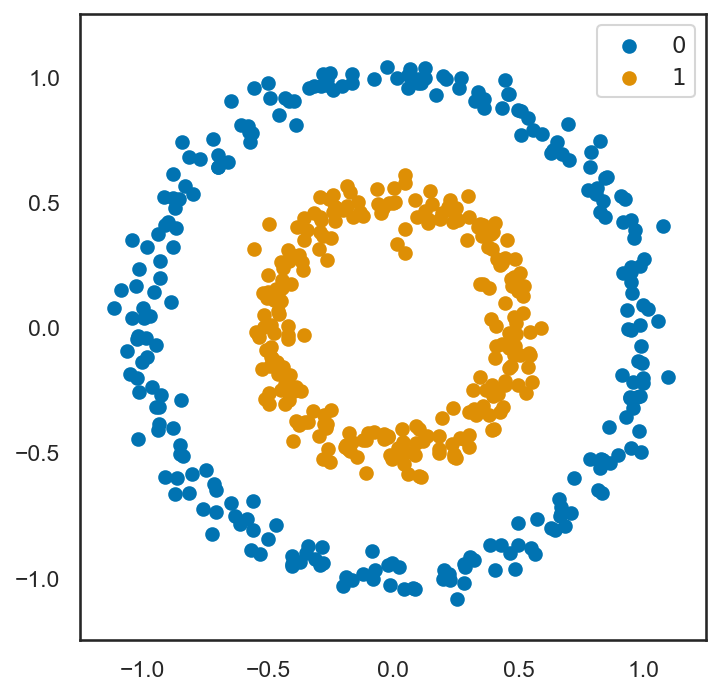

In [40]:
labels = ["$0$", "$1$"]
for i in range(len(labels)):
    idx = np.where(y_circ == i)
    plt.scatter(X_circ[idx, 0], X_circ[idx, 1], label=labels[i])
plt.xlim([-1.25, 1.25])
plt.ylim([-1.25, 1.25])
plt.gca().set_aspect("equal")
plt.legend()
plt.tight_layout()
plt.show()

このサンプルは、明らかに超平面(この場合は直線)では正しく二つのクラスを分割できないが、線形1学習して分類を行い、その予測結果に基づいて色づけを行うとどうなるだろうか。


In [41]:
clf = SVC(kernel="linear", C=1.0, tol=1.0e-2, max_iter=-1)
clf.fit(X_circ, y_circ)

SVC(kernel='linear', tol=0.01)

scikit-learn には`DecisionBoundaryDisplay`という関数が用意されており、これを用いると、どの部分に決定境界があるのかを可視化することができるので、今回はこれを用いる。


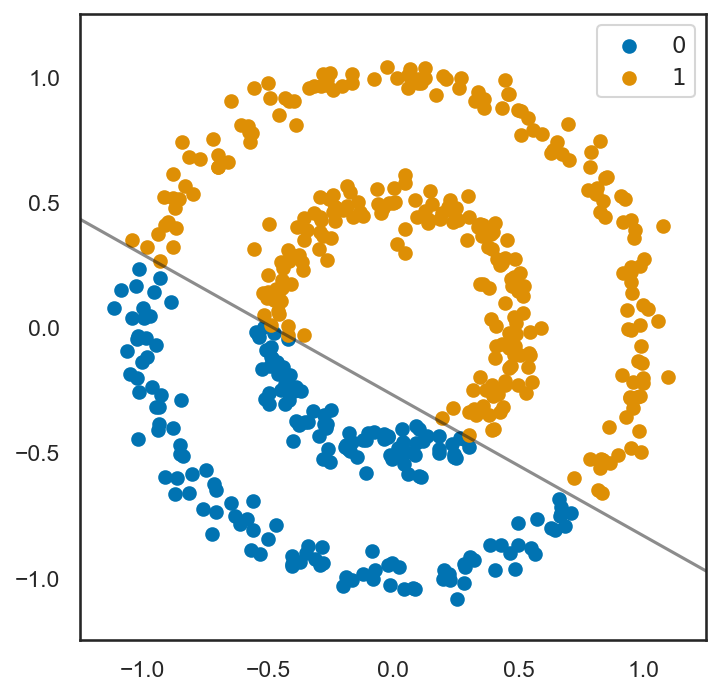

In [42]:
from sklearn.inspection import DecisionBoundaryDisplay

DecisionBoundaryDisplay.from_estimator(
    clf,
    X_circ,
    ax=plt.gca(),
    colors="k",
    plot_method="contour",
    alpha=0.5,
    levels=[-1, 0, 1],
    linestyles=["--", "-", "--"],
)

y_pred = clf.predict(X_circ)
labels = ["$0$", "$1$"]
for i in range(len(labels)):
    idx = np.where(y_pred == i)
    plt.scatter(X_circ[idx, 0], X_circ[idx, 1], label=labels[i])

plt.xlim([-1.25, 1.25])
plt.ylim([-1.25, 1.25])
plt.gca().set_aspect("equal")
plt.legend()
plt.tight_layout()
plt.show()

予想通り、線形SVMは正しく識別を行うことができておらず、不適切にサポートベクトルが与えられてしまっていることが分かる。

このような非線形の決定境界を持つようなモデルに対しては、カーネル法と呼ばれる方法でSVMを拡張する。これまで、サポートベクトルと点の間の距離は重み$\mathbf{a}$とサンプル$\mathbf{x}_i$の内積$\mathbf{a}^T \mathbf{x}_i$を用いて計算されてきたが、これを**カーネル関数**といういくつかの数学的な性質を満たす関数によって置き換える。

本題に入る前に、$\mathbf{x}_i = (x_i, y_i)$を変形して$(x_i, y_i, x_i^2 + y_i^2)$と置き換えたとしよう。すると、上記の2リングのサンプルの三次元プロットは以下のようになる。


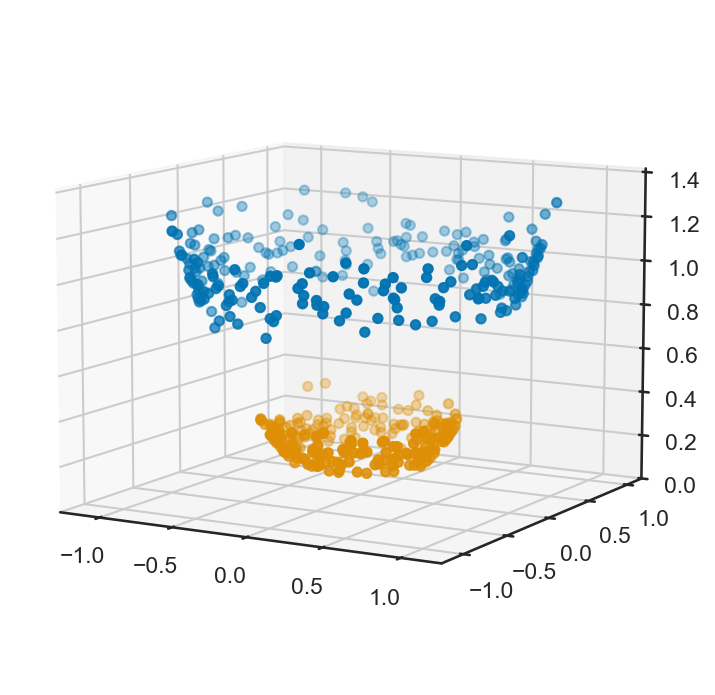

In [43]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.view_init(elev=10)

labels = ["$0$", "$1$"]
for i in range(len(labels)):
    idx = np.where(y_circ == i)
    ax.scatter(
        X_circ[idx, 0],
        X_circ[idx, 1],
        np.sum(X_circ[idx] ** 2, axis=1),
        label=labels[i],
    )

plt.tight_layout()
plt.show()

図から、何らかの変換により、次元を増やすことで、線形のSVMであっても上手く決定境界をきめることができそうであることが分かる。これがカーネル法の基本的なアイディアである。

例えば、多項式カーネルと呼ばれるカーネル関数:

$$
k(\mathbf{x}_i, \mathbf{x}_j) = (a + \mathbf{x}_i^T \mathbf{x}_k)^n
$$

において、$a=1$, $n=2$とすると、

$$
\begin{aligned}
k(\mathbf{x}_i, \mathbf{x}_j) &= (1 + x_i x_j + y_i y_j)^2 \\
&= 1 + 2x_i x_j + 2y_i y_j + (x_i x_j)^2 + (y_i y_j)^2 + 2(x_i x_j) (y_i y_j) \\
&= 1 + \sqrt{2}x_i \sqrt{2}x_j + \sqrt{2}y_i \sqrt{2}y_j + x_i^2 y_i^2 + x_j^2 y_j^2 + (\sqrt{2} x_i y_i) (\sqrt{2} x_j y_j) \\
&= (1, \sqrt{2}x_i, \sqrt{2}y_i, x_i^2, y_i^2, \sqrt{2} x_i y_i) \cdot (1, \sqrt{2}x_j, \sqrt{2}y_j, x_j^2, y_j^2, \sqrt{2} x_j y_j)
\end{aligned}
$$

のようになり、多項式カーネルが$(1, \sqrt{2}x_i, \sqrt{2}y_i, x_i^2, y_i^2, \sqrt{2} x_i y_i)$のような高次元表現における内積に対応していることが分かる。


「カーネル関数」は、上記の通り、何らかの高次元空間における内積を表わすように定義される。このような性質を満たすためには、カーネル関数$k$が$\mathbb{R}^d \times \mathbb{R}^d$から$\mathbb{R}$への写像であって、関数が**半正定値性**を持つ必要がある。

半正定値性、とは行列においては、任意のベクトルに対する二次形式が**0 以上**になることを指す。より厳密には、行列$\mathbf{A} \in \mathbb{R}^{d \times d}$が半正定値行列であるとは、

$$
\mathbf{x}^T \mathbf{A} \mathbf{x} \geq 0, \quad \forall \mathbf{x} \in \mathbb{R}^n
$$

を満たすことであり、上記の二次形式が**0より大きい場合** ($\mathbf{x}^T \mathbf{A} \mathbf{x} > 0$の場合)は行列$\mathbf{A}$が**正定値**であるという。


カーネル関数が半正定値である、というのも、これと類似しており、任意の$n \in \mathbb{N}$と、$\alpha_1, \ldots, \alpha_n \in \mathbb{R}$と$\mathbf{x}_1, \ldots, \mathbf{x}_n \in \mathbb{R}^d$について、以下の性質を満たすことを指す。

$$
\sum_{i=1}^n \alpha_i \alpha_j k(\mathbf{x}_i, \mathbf{x}_j) \geq 0
$$


この性質が満たされるとき、以下のような行列$K \in \mathbb{R}^{n \times n}$を考える。


$$
K=\begin{pmatrix}
k(\mathbf{x}_1, \mathbf{x}_1) & \cdots & k(\mathbf{x}_n, \mathbf{x}_1) \\
\vdots & \ddots & \vdots \\
k(\mathbf{x}_1, \mathbf{x}_n) & \cdots & k(\mathbf{x}_n, \mathbf{x}_n)
\end{pmatrix}
$$


この行列は、カーネル関数$k$の半正定値性から半正定値行列である。行列$K$は実対称行列であるので、固有値分解することにより、実数の固有値と互いに直交する実数の固有ベクトルが得られる。

$$
K = \Phi \Lambda \Phi^T
$$

以上より、得られた固有ベクトル$\phi(\mathbf{x}_1), \ldots, \phi(\mathbf{x}_n)$がとある$n$次元空間の正規直交基底となることが分かる。

すると、任意の$\sqrt{\lambda_i} \phi(\mathbf{x}_i)$、$\sqrt{\lambda_j} \phi(\mathbf{x}_j)$の組み合わせについて、カーネル関数により内積が定義できることになる。ここで内積が定義できるためには、固有値の平方根が実数である必要があるため、カーネル関数の半正定値性が必要だったのである。

この関数$\phi$こそが、前述の例で示した高次元空間への写像$(x, y) \mapsto (1, \sqrt{2} x, \sqrt{2}y, x^2, y^2, \sqrt{2} xy)$等に対応しており、カーネル法を用いたサポートベクトルマシンでは、元々$\mathbf{a}^T \mathbf{x} + b = 0$としていた直線の方程式をカーネル関数を用いて$k(\mathbf{a}, \mathbf{x}) + b = 0$と置き換えれば良い。


::::{warning}
上記は、数学的には厳密な議論ではなく、あくまで限られた$n$個のベクトル集合$\mathbf{x}_1, \ldots, \mathbf{x}_n$について、カーネル関数が内積を定義するような高次元空間への写像$\phi$が存在することを直感的に分かるように説明した。

より厳密な議論のためには、カーネル関数の連続性や二乗可積分性などの性質が必要になるが、これらの議論は別の専門書に譲ることとする。一例として、以下の教科書が詳しい。

赤穂 昭太郎 著、『カーネル多変量解析 -非線形データ解析の新しい展開-』、岩波書店、2008年
::::

カーネル関数の例としては、前述の多項式カーネルの他、RBF (radial basis function)カーネル、シグモイドカーネルなどがよく使われる。

- 多項式カーネル: $k(\mathbf{x}_i, \mathbf{x}_j) = (c + \gamma \mathbf{x}_i^\top \mathbf{x}_j)^n$
- RBF カーネル: $k(\mathbf{x}_i, \mathbf{x}_j) = \exp(-\gamma \| \mathbf{x}_i - \mathbf{x}_j \|^2)$
- シグモイドカーネル: $k(\mathbf{x}_i, \mathbf{x}_j) = \tanh (\gamma \mathbf{x}_i^\top \mathbf{x}_j + c)$
- コサインカーネル: $k(\mathbf{x}_i, \mathbf{x}_j) = \frac{\mathbf{x}_i^\top \mathbf{x}_j}{\| \mathbf{x}_i \| \| \mathbf{x}_j \|}$
- カイ二乗カーネル: $k(\mathbf{x}_i, \mathbf{x}_j) = \exp\left( -\gamma \sum_{k=1}^d \frac{(x_{i, k} - x_{j, k})^2}{x_{i, k} - x_{j, k}} \right)$

なお、これらのカーネル関数に対応する$\phi$は必ずしも解析的に書けるものばかりではなく、多項式カーネルは各次元が元のベクトルの要素からなる単項式となっており、RBF カーネルについては、元のベクトルの多項式 (無限級数)となることが知られている。

以下では、先ほどの2リングのサンプルについて、RBF カーネルを用いたサポートベクトルマシンを試してみる。なお、上記のカーネル関数のリストにおいて$c$と書いたパラメータは`SVC`においては`coef0=...` (初期値は 0)で、$\gamma$と書いたパラメータは`gamma=...`によって指定することができる。


In [44]:
clf = SVC(kernel="rbf", gamma=0.5, tol=1.0e-4, max_iter=20)
clf.fit(X_circ, y_circ)

SVC(gamma=0.5, max_iter=20, tol=0.0001)

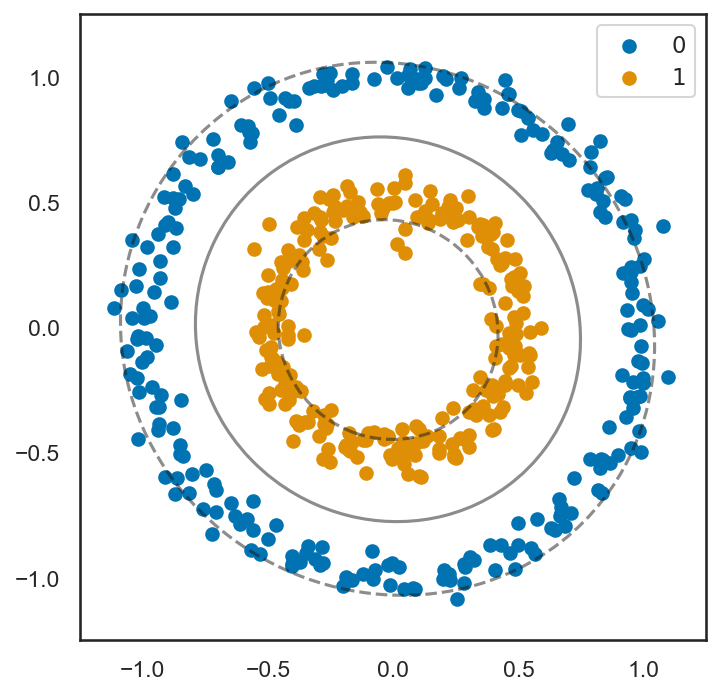

In [45]:
DecisionBoundaryDisplay.from_estimator(
    clf,
    X_circ,
    ax=plt.gca(),
    colors="k",
    plot_method="contour",
    alpha=0.5,
    levels=[-1, 0, 1],
    linestyles=["--", "-", "--"],
)

y_pred = clf.predict(X_circ)
labels = ["$0$", "$1$"]
for i in range(len(labels)):
    idx = np.where(y_pred == i)
    plt.scatter(X_circ[idx, 0], X_circ[idx, 1], label=labels[i])

plt.xlim([-1.25, 1.25])
plt.ylim([-1.25, 1.25])
plt.gca().set_aspect("equal")
plt.legend()
plt.tight_layout()
plt.show()

図の通り、カーネル関数を用いることにより、必ずしも超平面では分割できないような対象に対しても、正しく分類ができていることが分かる。


カーネル関数の効果が確認できたところで、MNISTの分類にこれを利用してみる。プログラムは先ほどからほとんど変更する必要はない。

In [46]:
# 訓練モデルの構築
clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="rbf", C=1.0, tol=1.0e-2, max_iter=-1),
)
clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC(tol=0.01))])

In [47]:
# 識別精度の確認
acc_train = clf.score(X, y)
acc_test = clf.score(X_test, y_test)

In [48]:
glue("ksvm_acc_train", acc_train * 100.0)
glue("ksvm_acc_test", acc_test * 100.0)
result_df.loc[len(result_df), :] = ["Kernel SVM", acc_train, "Train"]
result_df.loc[len(result_df), :] = ["Kernel SVM", acc_test, "Test"]

98.4

94.19999999999999

**結果: カーネルSVMのよる分類**

- 訓練時精度: {glue:text}`ksvm_acc_train:.2f`%
- 評価時精度: {glue:text}`ksvm_acc_test:.2f`%


::::{admonition} 問
:class: question

scikit-learn の`SVC`には`kernel=...`の引数に直接カーネル関数を渡すことができる。これを用いて、コサイン・カーネルならびにカイ二乗カーネルについて性能を評価せよ。

::::

## ここまでの手法の比較

最後にここまでの手法をグラフで比較すると、以下のようになる。手法選びの参考にしてほしい。


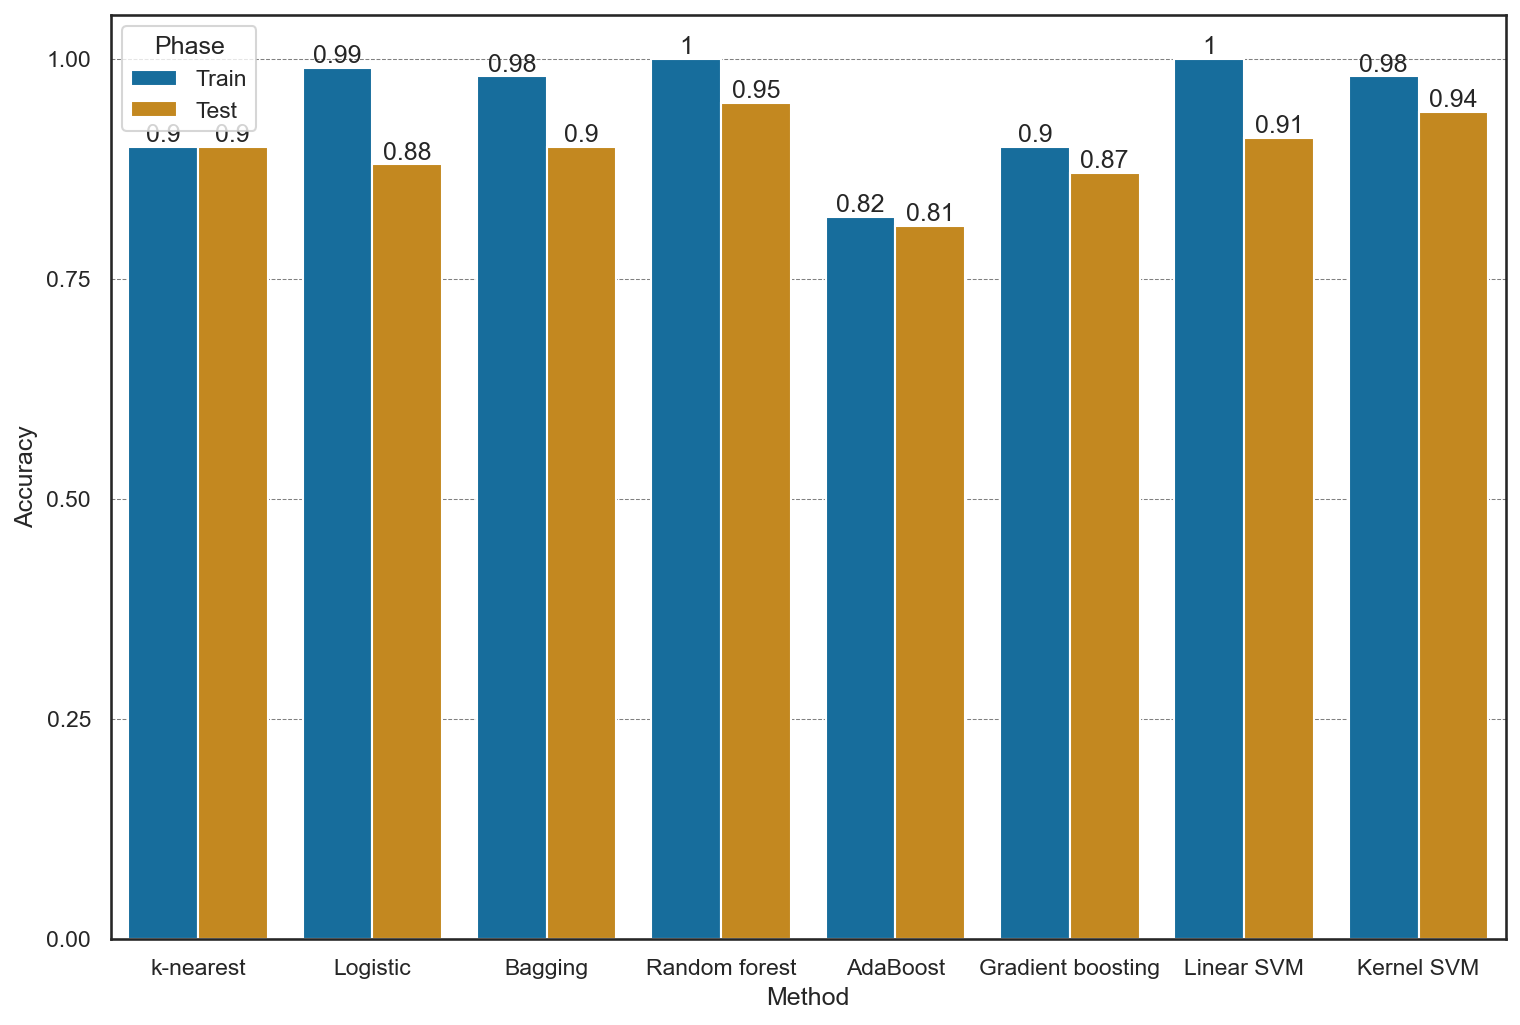

In [49]:
plt.figure(figsize=(12, 8))

ax = sns.barplot(
    x="Method",
    y="Accuracy",
    hue="Phase",
    data=result_df.round(2),
    errwidth=0,
)

for i in ax.containers:
    ax.bar_label(i)

plt.yticks(np.linspace(0.0, 1.0, 5))
plt.ylim([0.0, 1.05])
plt.grid(axis="y", color="gray", linestyle="--", linewidth=0.5)
plt.show()

## ハイパーパラメータの調整


機械学習においては、学習モデルが持つパラメータで、訓練データから決定されるものを指して「パラメータ」という言葉を用いるのが一般的である。一方で、訓練時の学習率など、学習モデル自体とは関係のないパラメータを**ハイパーパラメータ**と呼ぶ。

これまでに示した機会分類モデルのプログラムではscikit-learnによって予め与えられたハイパーパラメータを用いて実験を行なってきた。一方、ハイパーパラメータの設定によっては、訓練データに過剰適合するなどして、パフォーマンスが上がらないことがある。

このような時には、何らかの方法で適切なハイパーパラメータ (カーネルSVMの例では`kernel`や`C`)を見つける必要がある。

### ホールドアウト検証


広く用いられるハイパーパラメータの決定法はデータセットを訓練、検証、テストの三つのデータに分けて、検証用データに対するパフォーマンスが高くなるようなハイパーパラメータを設定する方法である。このような方法を**ホールドアウト検証**と呼ぶ。


In [50]:
# データセットを3つに分割
# 訓練: 50000, 検証: 10000, テスト: 10000
X, X_test, y, y_test = model_selection.train_test_split(
    X_org, y_org, train_size=60000, test_size=10000, shuffle=True
)

X, X_val, y, y_val = model_selection.train_test_split(
    X, y, train_size=50000, test_size=10000, shuffle=True
)

# 計算量を落とすため、訓練データの数を絞る
X, y = X[:n_samples], y[:n_samples]
X_val, y_val = X_val[:n_samples], y_val[:n_samples]
X_test, y_test = X_test[:n_samples], y_test[:n_samples]

検証用のデータが用意できたら、検証するハイパーパラメータの範囲を設定し、グリッドサーチと呼ばれる方法で、あらゆる組み合わせのパラメータについて検証用データに対する性能を比較する。ハイパーパラメータの組み合わせの中で、検証用データに対する性能が高かったものを最終的なパラメータとして設定する。

なお、グリッドサーチはハイパーパラメータの組み合わせ数によっては、非常に時間がかかるため、モデルの訓練に必要な最適化の繰り返し回数(`max_iter`)や許容誤差(`tol`)を甘めに設定しておくと良い。


In [51]:
from itertools import product

# グリッドサーチによる最適パラメータを探索
max_acc = 0.0
best_params = None

kernel_types = ["linear", "rbf", "poly"]
C_values = [0.01, 0.1, 1.0, 10.0, 100.0]
param_grid = {"kernel": kernel_types, "C": C_values}
gs_df = pd.DataFrame(columns=(list(param_grid.keys()) + ["Accuracy"]))

best_index = 0
param_sets = list(product(*param_grid.values()))
for i, params in enumerate(tqdm(param_sets)):
    param_dict = {list(param_grid.keys())[i]: v for i, v in enumerate(params)}
    clf = make_pipeline(
        StandardScaler(),
        SVC(tol=1.0e-4, max_iter=20, **param_dict),
    )
    clf.fit(X, y)

    # 精度の計算
    acc_val = clf.score(X_val, y_val)

    # データを追加
    new_row = {k: v for k, v in param_dict.items()}
    new_row["Accuracy"] = acc_val
    gs_df.loc[len(gs_df), :] = list(new_row.values())

    # ベスト・パラメータの更新
    if max_acc < acc_val:
        best_index = i
        max_acc = acc_val
        best_params = param_dict

  0%|          | 0/15 [00:00<?, ?it/s]

In [52]:
def custom_style(df):
    index = df.index
    columns = df.columns
    styles = []
    for i in range(len(index)):
        s = []
        for j in range(len(columns)):
            if i == best_index:
                s.append("background-color: pink; font-weight: bold;")
            else:
                s.append(None)
        styles.append(s)

    return np.array(styles, dtype="object")


gs_df.style.apply(custom_style, axis=None)

,kernel,C,Accuracy
0,linear,0.010000,0.731400
1,linear,0.100000,0.733500
2,linear,1.000000,0.733500
3,linear,10.000000,0.733500
4,linear,100.000000,0.733500
5,rbf,0.010000,0.681500
6,rbf,0.100000,0.670800
7,rbf,1.000000,0.753300
8,rbf,10.000000,0.801100
9,rbf,100.000000,0.801100


最適なパラメータが決定できたら、繰り返し回数や許容誤差を正しく設定して、再度モデルを学習する。


In [53]:
# 最適パラメータでの再学習
clf = make_pipeline(
    StandardScaler(),
    SVC(tol=1.0e-4, max_iter=-1, **best_params),
)
clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=10.0, tol=0.0001))])

In [54]:
# 識別精度の確認
acc_train = clf.score(X, y)
acc_test = clf.score(X_test, y_test)

In [55]:
glue("ho_acc_train", acc_train * 100.0)
glue("ho_acc_test", acc_test * 100.0)
result_df.loc[len(result_df), :] = ["Holdout K-SVM", acc_train, "Train"]
result_df.loc[len(result_df), :] = ["Holdout K-SVM", acc_test, "Test"]

99.95

94.92

**結果: ホールドアウト検証の結果**

- 訓練時精度: {glue:text}`ho_acc_train:.2f`%
- 評価時精度: {glue:text}`ho_acc_test:.2f`%


この通り、ホールドアウト検証を実行したことで、より高い分類精度が得られていることが分かる。


### 交差検証 (クロス・バリデーション)

もう一つのよく用いられるハイパーパラメータの調整方法に交差検証(クロス・バリデーション)がある。交差検証は訓練データをいくつかのグループに分けて、そのグループのうち1つを除いたデータを訓練に用い、除いておいた1グループを検証に用いる、というものである。

交差検証は、グループが$G$個あるとき、1つのパラメータセットについて$G$回の訓練と$G$回の検証が必要になるため、非常に計算量が大きい。

ここでは、scikit-learn に用意されている`GridSearchCV` (grid search cross validation)を用いて交差検証によるハイパーパラメータ調整を試してみる。

なお、`GridSearchCV`で`make_pipeline`等で作成したパイプラインのハイパーパラメータを調整する場合、モデル名を小文字表記したもの(`SVC`なら`svc`)とハイパーパラメータ名 (`kernel`など)をアンダーバー2つで結んだものパラメータ名として用いる (以下の例を参照)。

In [57]:
from sklearn.model_selection import GridSearchCV

kernel_types = ["linear", "rbf", "poly"]
C_values = [0.01, 0.1, 1.0, 10.0, 100.0]
param_grid = {"svc__kernel": kernel_types, "svc__C": C_values}

clf = make_pipeline(StandardScaler(), SVC(tol=1.0e-4, max_iter=20))
cv = GridSearchCV(clf, param_grid, cv=4, n_jobs=8, verbose=2)
ret = cv.fit(X, y)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


In [58]:
import pandas as pd
from IPython import display

df = pd.DataFrame.from_dict(ret.cv_results_)
df.drop(df.columns[:4], axis=1, inplace=True)
df.drop("params", axis=1, inplace=True)
display.display(df)

,param_svc__C,param_svc__kernel,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.01,linear,0.7400,0.7508,0.7236,0.7696,0.7460,0.016716,8
1,0.01,rbf,0.6920,0.6932,0.6708,0.6800,0.6840,0.009204,10
2,0.01,poly,0.1820,0.1172,0.1288,0.1344,0.1406,0.024694,12
3,0.10,linear,0.8032,0.7384,0.7468,0.7584,0.7617,0.024990,4
4,0.10,rbf,0.7024,0.6872,0.6788,0.7040,0.6931,0.010543,9
5,0.10,poly,0.1700,0.1052,0.1032,0.1724,0.1377,0.033518,13
6,1.00,linear,0.8032,0.7384,0.7468,0.7584,0.7617,0.024990,4
7,1.00,rbf,0.7840,0.7776,0.7416,0.7720,0.7688,0.016268,3
8,1.00,poly,0.1068,0.1136,0.1032,0.1600,0.1209,0.022881,15
9,10.00,linear,0.8032,0.7384,0.7468,0.7584,0.7617,0.024990,4


最良のハイパーパラメータを使って再学習を行なう場合には、`make_pipeline`等で同様のパイプラインを作成後に`set_params`メソッドを呼び出してハイパーパラメータを設定する。

In [59]:
clf = make_pipeline(StandardScaler(), SVC(tol=1.0e-4, max_iter=-1))
clf.set_params(**ret.best_params_)
clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=10.0, tol=0.0001))])

In [60]:
# 識別精度の確認
acc_train = clf.score(X, y)
acc_test = clf.score(X_test, y_test)

In [61]:
glue("cv_acc_train", acc_train * 100.0)
glue("cv_acc_test", acc_test * 100.0)
result_df.loc[len(result_df), :] = ["CV K-SVM", acc_train, "Train"]
result_df.loc[len(result_df), :] = ["CV K-SVM", acc_test, "Test"]

99.95

94.92

**結果: 交差検証の結果**

- 訓練時精度: {glue:text}`cv_acc_train:.2f`%
- 評価時精度: {glue:text}`cv_acc_test:.2f`%

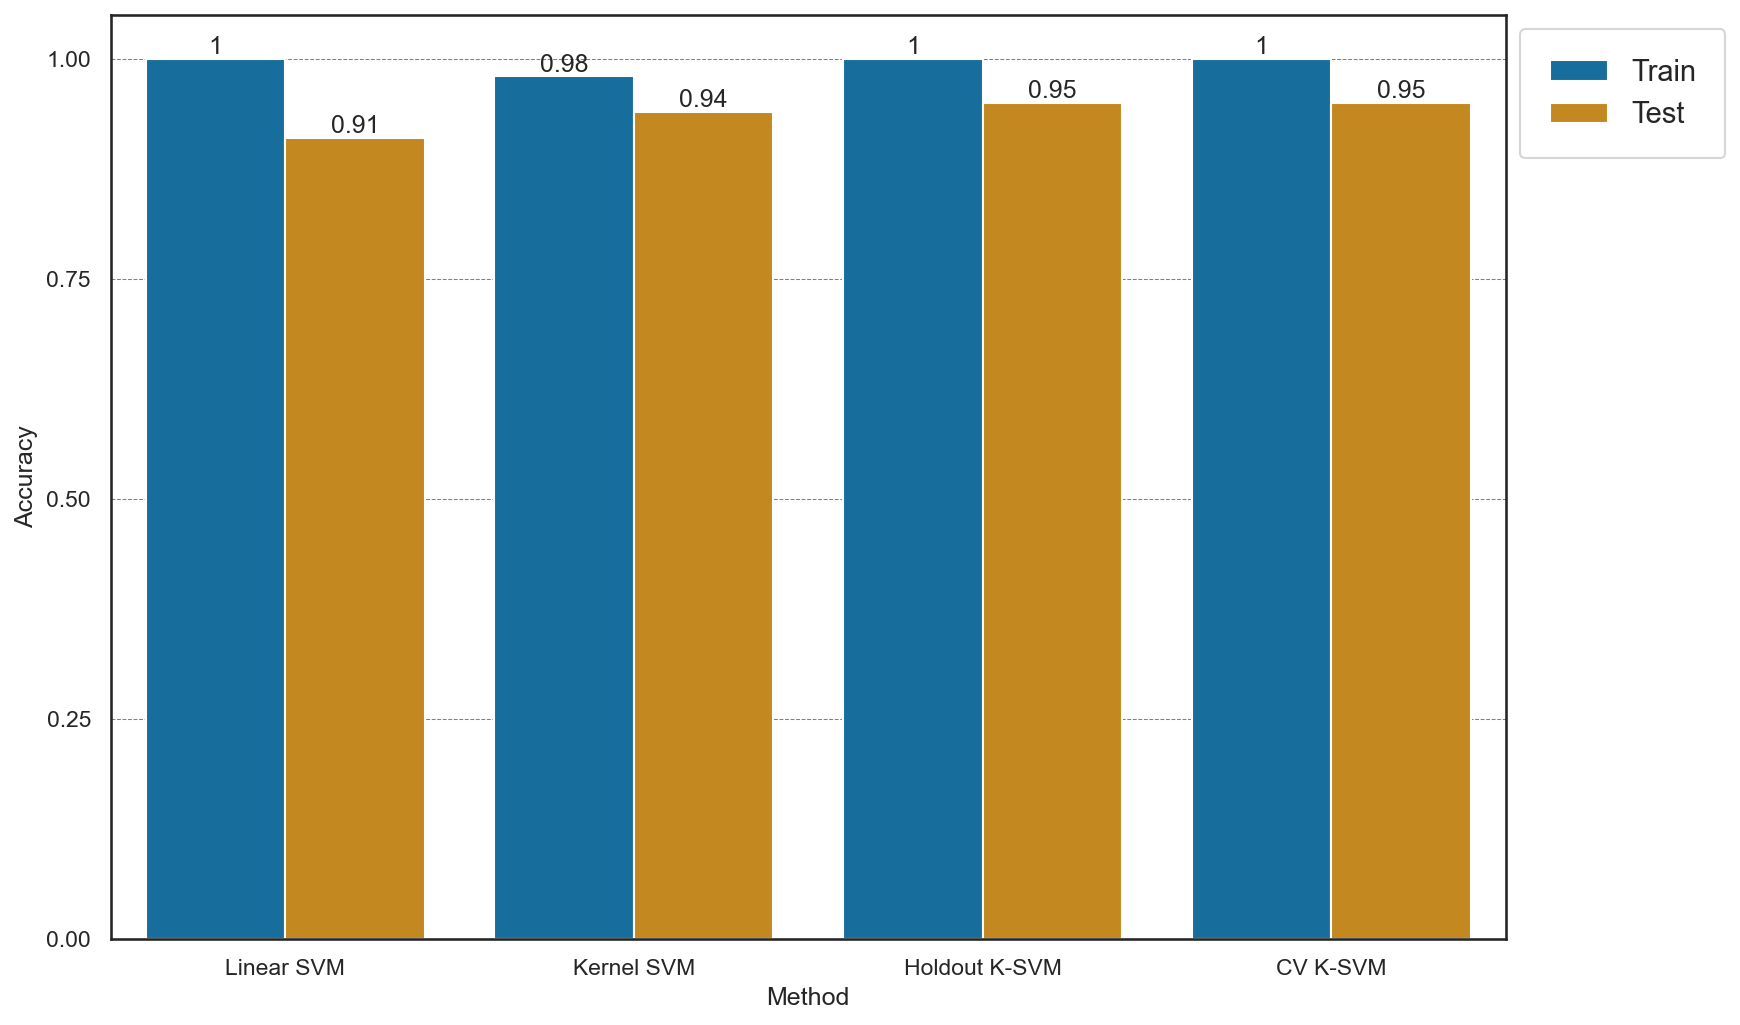

In [62]:
plt.figure(figsize=(12, 8))

fil = result_df.iloc[:, 0].str.contains("SVM")
ax = sns.barplot(
    x="Method",
    y="Accuracy",
    hue="Phase",
    data=result_df[fil].round(2),
    errwidth=0,
)

for i in ax.containers:
    ax.bar_label(i)

plt.yticks(np.linspace(0.0, 1.0, 5))
plt.ylim([0.0, 1.05])
plt.grid(axis="y", color="gray", linestyle="--", linewidth=0.5)
plt.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0), borderpad=1, fontsize=14)
plt.show()

### 学習済みデータの保存


ハイパーパラメータの調整が完了したら、学習済みのモデルをファイルに保存し、再学習なしで、テストに入れるようにしておこう。

通常、モデルは複数のパラメータから構成されており、これらをファイルに保存できるような「文字列」や「バイト列」の集合に変換する操作を**シリアライズ**と呼ぶ。また、このようなシリアライズを行うプログラムを**シリアライザ**と呼ぶ。

Python で標準使用できるシリアライザには`pickle`がある。`pickle`はPythonの標準的なオブジェクト (例えば`list`や`dict`や、その他のオブジェクト)をシリアライズしたバイトデータを作成してくれるので、それをファイルに保存すれば良い。

先ほどハイパーパラメータを調整したSVMのモデルを保存し、それを再度読み込んで精度が保たれていることを確認してみる。


In [63]:
import pickle

# 学習済みモデルの保存
with open("svm.pickle", "wb") as f:
    pickle.dump(clf, f)

In [64]:
# 再読み込みとテスト
clf2 = None
with open("svm.pickle", "rb") as f:
    clf2 = pickle.load(f)

acc_test = clf2.score(X_test, y_test)
print(f"CV: acc(test)={100.0 * acc_test:.2f}%")

CV: acc(test)=94.92%


このように、保存しておいたファイルから全く同じテスト精度が得られることが確認できた。

また、同様のシリアライザに並列計算のためのライブラリである`joblib`を用いる方法もある。

`joblib`にも`pickle`と同様の`joblib.dump`と`joblib.load`が用意されている。`pickle`とほとんど同じ動作であるが、`joblib`の方は`dump`、`load`の引数にファイルオブジェクトではなくファイル名が直接指定でき、さらに`dump`にはファイルの圧縮レベル`compress`が設定できる(0-9の値で、標準値は3)。

In [65]:
import joblib

# ファイルへの保存
joblib.dump(clf, "rbf_svm.joblib", compress=3)

# 再読み込みとテスト
clf3 = joblib.load("rbf_svm.joblib")
acc_test = clf3.score(X_test, y_test)
print(f"CV: acc(test)={100.0 * acc_test:.2f}%")

CV: acc(test)=94.92%


::::{admonition} 問
:class: question

事前学習済みのモデルを`pickle`と`joblib`を用いて保存した際のファイルサイズを比較せよ。また、線形SVMとカーネルSVMの事前学習済みモデルを保存した場合のファイルサイズを比較し、サイズ差が生じる原因について考察せよ。

::::

## 分類問題の評価方法


ここまで、分類の精度を「どの程度正しく分類ができたか」について評価してきたが、この評価方法は必ずしも、分類器の性能を正しく評価するとは言い切れない。例えば、数字の識別問題において、データセットに含まれる数字の90%が0、残りの10%がそれ以外であったとする。

この場合、識別器がどんな画像が入力されても「0」だと認識するようになれば、90%の識別精度が得られることになるが、これは全ての数字を正しく識別しているとは言いがたい。

### 2 クラス分類の場合


多クラス識別の問題について考える前に、2クラスの分類問題について考えてみる。例えば、とあるデータからある人が病気なのか、そうでないのかを識別するとしよう。

この場合、以下の4つの場合が考えられる。

- 正陽性 (true positive): 病気の人を、正しく病気と判別した
- 偽陽性 (false positive): 病気でない人を、間違って病気と判別した
- 正陰性 (true negative): 病気でない人を、正しく病気と判別した
- 偽陰性 (false negative): 病気の人を、間違って病気でないと判別した

以上を表にまとめると、以下のようになる。

In [66]:
import pandas as pd
from IPython import display

html_text = """
<table style="width: 80%;">
    <thead>
        <tr>
            <th></th>
            <th></th>
            <th style="text-align:center;" colspan="2">正解</td>
        </tr>
    </thead>
    <tr>
        <td style="width: 25%; text-align: center;"></td>
        <td style="width: 25%; text-align: center;"></td>
        <td style="width: 25%; text-align: center;">病気である</td>
        <td style="width: 25%; text-align: center;">病気でない</td>
    </tr>
    <tr>
        <td rowspan="2" style="background: white; text-align: center;">
            <span style="font-weight: bold;">予想</span>
        </td>
        <td style="width: 25%; text-align: center;">病気である</td>
        <td style="width: 25%; text-align: center;">正陽性 (TP)</td>
        <td style="width: 25%; text-align: center;">偽陽性 (FP)</td>
    </tr>
    <tr>
        <td style="width: 25%; text-align: center;">病気でない</td>
        <td style="width: 25%; text-align: center;">偽陰性 (FN)</td>
        <td style="width: 25%; text-align: center;">偽陽性 (TN)</td>
    </tr>
</table>
"""

display.HTML(html_text)

この表記を用いた場合、ここまで用いてきた「精度 (Accuracy)」は以下のように定義できる。

$$
\text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}
$$


この精度は前述の通り、データに偏りがある場合には必ずしも正しい評価指標とは言えない。多くの場合、病気である人と、病気でない人は病気でない人の方が多数派だと考えられる。仮に分類器が全ての人に対して「病気でない」と判別したとすれば、かなり高い精度が得られるが、これは分類器としては失格で、本来見つけたい病気の人を見つけることができない。


精度の問題を解決する考え方には、**適合率**(precision)と**再現率**(recall)がある。

適合率とは、正しい識別が行えたもの(正陽性 (TP)と正陰性 (FN)の和)に対する正陽性(TP)の割合を指し、識別すべき対象をどれだけ正しく分類できたかを表す。

$$
\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{TN}}
$$

再現性とは、陽性であると識別したもの(正陽性 (TP)と偽陽性 (FP)の和)に対する正陽性(TP)の割合を指し、陽性であると判別された人が、本当はどの程度の割合で陽性なのかを表わす。

$$
\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FP}}
$$


適合率と再現度を用いる場合、全ての人を病気でない、と分類する分類器はTPが0になるので、適合率と再現率はいずれも0となり、改善が必要であることが分かる。

一方で、仮に識別器が全ての人を病気である、と分類する分類器を考えると、仮に病気になる人の割合が1%である場合、TPが全体の1%, FPが全体の99%となるので再現率は0.01となる。従って、このような分類器も適合率・再現率の観点からは適切な分類器とは言えない。

実際のところ、適合率と再現率は互いに相反する関係にあり、適合率を上げるように意図的に判別を偏らせれば再現率が下がり、逆に再現率を上げるように意図的に判別を偏らせれば適合率が下がる。よって、両者がバランス良く高いことを示す指標としてF1値がある。

F1値は適合率と再現率の調和平均 (「逆数の平均」の逆数)によって、以下のように表せる。

$$
\text{F}_1 = \left[ \frac{1}{2} \left( \frac{1}{\text{Accuracy}} + \frac{1}{\text{Recall}} \right) \right]^{-1} = \frac{2 \cdot \text{Accuracy} \cdot \text{Recall}}{\text{Accuracy} + \text{Recall}}
$$


この指標は適合率と再現率の両方が1に近い時に、より1に近い値を取るような指標で、適合率のみ、再現率のみを用いた評価の問題点を上手く解決している。

::::{note}
F1値の名前にある「1」は適合率と再現率を等しい重要度として評価していることを示している。F1値を適合率の重要度を係数$\beta^2$で重み付けして、調和平均を取った指標に$F_\beta$値がある。$F_\beta$値は次の式で表せる。

$$
\text{F}_\beta = \left[ \frac{1}{1 + \beta^2} \left( \beta^2 \frac{1}{\text{Accuracy}} + \frac{1}{\text{Recall}} \right) \right]^{-1} = \frac{(1 + \beta^2) \cdot \text{Accuracy} \cdot \text{Recall}}{\beta^2 \text{Accuracy} + \text{Recall}}
$$
::::


### 多クラス分類の場合


多クラス分類に対しても、精度(accuracy)、適合率(precision)、再現率(recall)、ならびにF1値と類似した指標を計算することができる。

本題に入る前に、先ほど交差検定を用いて学習を行った分類器を、混合行列により評価してみる。混合行列の可視化にはscikit-learnの`ConfusionMatrixDisplay`を用いると良い。

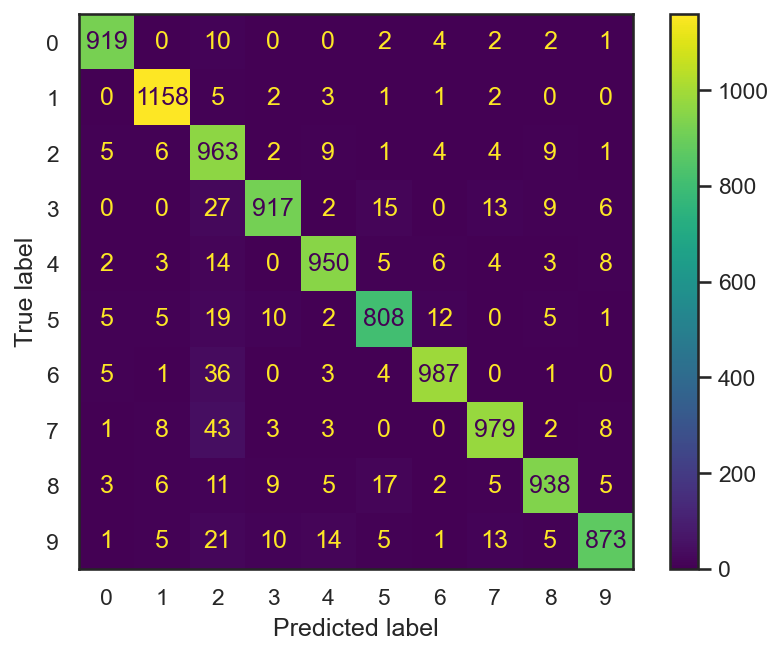

In [67]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure()
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=plt.gca())
plt.show()

上記の混同行列は、2クラス分類の場合に示した2×2の表を拡張したものである。

混同行列の各行を横に見ると、とある数字であると判別したもののうち、実際にその数字であったものの割合が計算でき、これが再現率(recall)に対応する。反対に、混同行列の各列を縦に見ると、とある数字が書かれた画像のうち、学習モデルにより正しく数字を当たられたものの割合を計算でき、これが適合率(precision)に対応する。

ここで$K$クラスの識別問題に対する混同行列を$\mathbf{C} \in \mathbb{R}^{K \times K}$と表わす。すると、各クラス$k \in \{ 1, \ldots, K \}$に対する適合率$P_k$と再現率$R_k$ならびにF1値$F_k$は以下の式で計算できる。

$$
\begin{align*}
P_k &= \frac{C_{kk}}{\sum_{i=1}^{K} C_{ik}} \\
R_k &= \frac{C_{kk}}{\sum_{i=1}^{K} C_{ki}} \\
F_k &= \frac{2 P_k R_k}{P_k + R_k}
\end{align*}
$$

このように、各クラスに対して計算された指標をクラス全体で平均した指標を**マクロ平均**と呼び、以下のように定義できる。

$$
\begin{align*}
\text{macro-Precision} &= \frac{1}{K} \sum_{k=1}^K P_k \\
\text{marco-Recall} &= \frac{1}{K} \sum_{k=1}^K R_k \\
\text{marco-F}_1 &= \frac{1}{K} \sum_{k=1}^K F_k
\end{align*}
$$


一方で、マクロ平均は、病気の例の時と同様に、各クラスに属するサンプル数に偏りがある場合には、よりサンプル数が多いクラスの識別結果から強く影響を受けることになる。

そこで、クラスの違いを考慮せずに適合率、再現率であるマイクロ平均を以下のように計算する (結果的には同じ値になるが、考え方として分母の$\mathbf{C}$に対する添え字$k$と$l$の順序が異なる)。

$$
\begin{align*}
\text{micro-Precision} &= \frac{\sum_{k=1}^K C_{kk}}{\sum_{k=1}^K \sum_{l=1}^K C_{lk}} \\
\text{micro-Recall} &= \frac{\sum_{k=1}^K C_{kk}}{\sum_{k=1}^K \sum_{l=1}^K C_{kl}}
\end{align*}
$$

このように、マイクロ平均では、適合率も再現率も同じ値になるので、F1 値のマイクロ平均も同じ値になる。


これらの値をscikit-learnを用いて計算してみよう。先ほどは分類器を`ConfusionMatrixDisplay`に渡して、直接、混同行列を可視化していたが`confusion_matrix`関数を用いると、行列の値を取り出すことができる。


In [68]:
from sklearn.metrics import confusion_matrix

# 混同行列の計算
y_pred = clf.predict(X_test)
C = confusion_matrix(y_test, y_pred)

In [69]:
# マクロ平均の計算
P_k = np.diag(C) / np.sum(C, axis=0)
R_k = np.diag(C) / np.sum(C, axis=1)
F_k = (2.0 * P_k * R_k) / (P_k + R_k)
macro_P = np.mean(P_k)
macro_R = np.mean(R_k)
macro_F = np.mean(F_k)

In [70]:
glue("macro-p", macro_P * 100.0)
glue("macro-r", macro_R * 100.0)
glue("macro-f", macro_F * 100.0)

95.07037909421369

94.83585375666183

94.8984649946653

**結果: マクロ平均の値**

- macro-P: {glue:text}`macro-p:.3f`
- macro-R: {glue:text}`macro-r:.3f`
- macro-F: {glue:text}`macro-f:.3f`


In [71]:
# マイクロ平均の計算
micro_avg = np.sum(np.diag(C)) / np.sum(C)

In [72]:
glue("micro-avg", micro_avg * 100.0)

94.92

**結果: マイクロ平均の値**

- maicro-avg: {glue:text}`micro-avg:.3f`


::::{admonition} 問
:class: question

マクロ平均ならびにマイクロ平均を用いて、本節で紹介した分類手法の性能を比較せよ。

::::

## 参考文献

```{bibliography}
:filter: docname in docnames
:style: alpha
```
